In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [ ]:
# A faire : penser à ajouter une période de rodage
# Et regarder les auto-corrélations
# Amincissement si besoin

In [2]:
# échantillonneur de gibbs

def gibbs(mu_0, phi_0, c_0, nb_it, X, sigma):
    K = len(mu_0)
    n = len(X)

    mu_mcmc = np.empty((nb_it + 1, K))
    mu_mcmc[0] = mu_0
    c_mcmc = np.empty((nb_it + 1, n, K))
    c_mcmc[0] = c_0
    phi_mcmc = np.empty((nb_it + 1, n, K))
    phi_mcmc[0] = phi_0

    for l in range(nb_it):
        # Mise à jour sur mu
        for k in range(K):
            mu_var = 1 / (1 / sigma**2 + np.sum(phi_mcmc[l, :, k]))
            mu_mean = np.dot(X, phi_mcmc[l, :, k]) * mu_var
            mu_mcmc[l + 1, k] = np.random.normal(mu_mean, np.sqrt(mu_var))

        # Mise à jour sur les proba d'assignation (phi)
        for i in range(n):
            for k in range(K):
                phi_mcmc[l + 1, i, k] = np.exp(-(X[i] - mu_mcmc[l + 1, k])**2 / 2)
            phi_mcmc[l + 1, i, :] /= np.sum(phi_mcmc[l + 1, i, :])
            c_mcmc[l + 1, i] = np.random.multinomial(1, phi_mcmc[l + 1, i], 1)

    return mu_mcmc, c_mcmc, phi_mcmc

In [3]:
def gmm_rand(N, nb_clusters, pi, mu):
    data = np.zeros(N)
    cluster_indices = np.random.choice(nb_clusters, size=N, p=pi)
    for i in range(N):
        data[i] = np.random.normal(mu[cluster_indices[i]], 1)
    return data

def gmm_pdf(x, pi, mu):
    res = 0
    for k in range(len(pi)):
        res += pi[k] * norm.pdf(x, mu[k], 1)
    return res


In [4]:
N = 1000
nb_clusters = 2
nb_it = 1000
pi = [0.5, 0.5]
sigma = 10

mu_priore = [np.random.normal(0, sigma) for k in range(nb_clusters)]
donnees = gmm_rand(N, 2, pi, mu_priore)

c_0 = np.zeros((N, nb_clusters))
for i in range(N):
    c_0[i, np.random.choice(nb_clusters)] = 1

mu_mcmc, c_mcmc, phi_mcmc = gibbs(mu_priore, pi, c_0, nb_it, donnees, sigma)


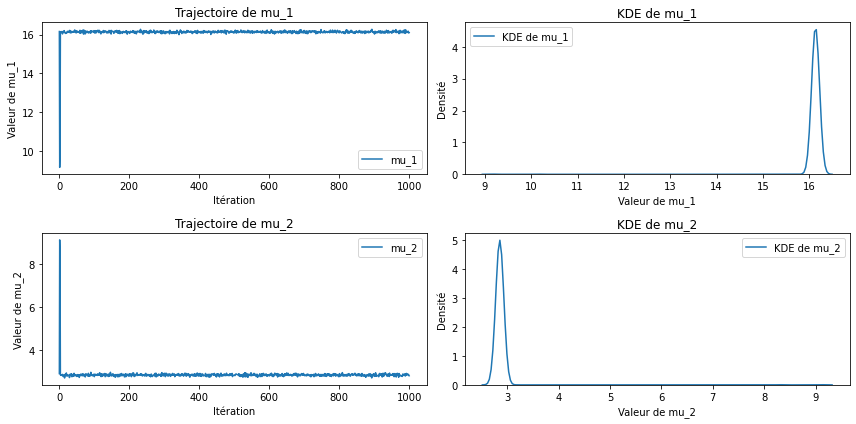

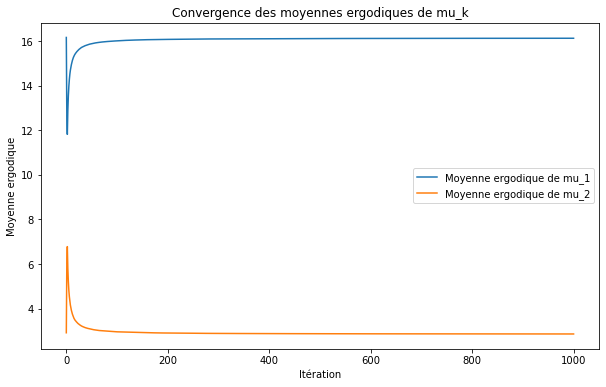

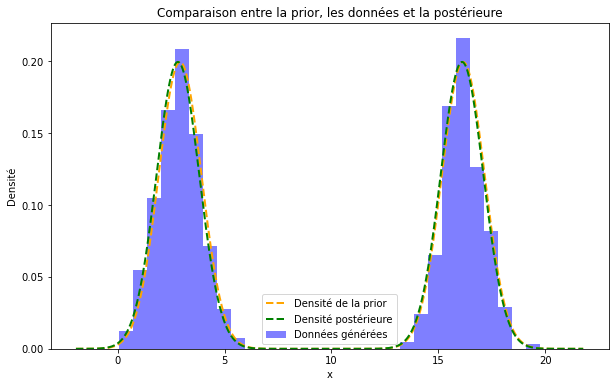

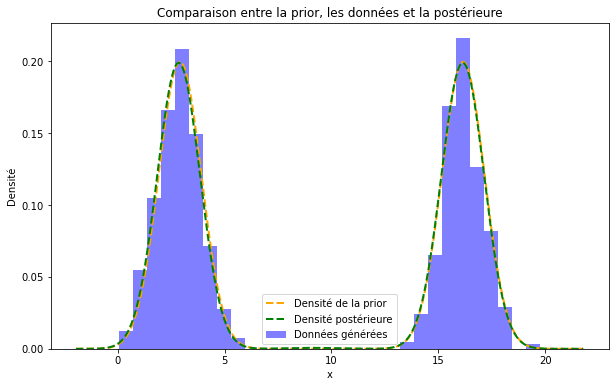

In [5]:
fig, axes = plt.subplots(nb_clusters, 2, figsize=(12, 6))
for k in range(nb_clusters):
    axes[k, 0].plot(mu_mcmc[:, k], label=f"mu_{k+1}")
    axes[k, 0].set_title(f"Trajectoire de mu_{k+1}")
    axes[k, 0].set_xlabel('Itération')
    axes[k, 0].set_ylabel(f'Valeur de mu_{k+1}')
    axes[k, 0].legend()

    sns.kdeplot(mu_mcmc[:, k], ax=axes[k, 1], label=f"KDE de mu_{k+1}")
    axes[k, 1].set_title(f"KDE de mu_{k+1}")
    axes[k, 1].set_xlabel(f'Valeur de mu_{k+1}')
    axes[k, 1].set_ylabel('Densité')
    axes[k, 1].legend()

plt.tight_layout()
plt.show()

mu_ergodique = np.cumsum(mu_mcmc, axis=0) / (np.arange(nb_it + 1)[:, None] + 1)

plt.figure(figsize=(10, 6))
for k in range(nb_clusters):
    plt.plot(mu_ergodique[:, k], label=f"Moyenne ergodique de mu_{k+1}")

plt.xlabel("Itération")
plt.ylabel("Moyenne ergodique")
plt.title("Convergence des moyennes ergodiques de mu_k")
plt.legend()
plt.show()

xx = np.linspace(min(donnees) - 2, max(donnees) + 2, 1000)
prior_density = gmm_pdf(xx, pi, mu_priore)
posterior_density = gmm_pdf(xx, pi, mu_mcmc[-1])

plt.figure(figsize=(10, 6))
plt.hist(donnees, density=True, bins=30, alpha=0.5, label="Données générées", color="blue")
plt.plot(xx, prior_density, label="Densité de la prior", color="orange", linestyle="dashed", lw=2)
plt.plot(xx, posterior_density, label="Densité postérieure", color="green", linestyle="dashed", lw=2)
plt.xlabel("x")
plt.ylabel("Densité")
plt.title("Comparaison entre la prior, les données et la postérieure")
plt.legend()
plt.show()

# Fonction pour calculer la densité postérieure en utilisant toute la chaîne MCMC
def posterior_density_using_chain(x, pi, mu_mcmc):
    """
    Calcule la densité postérieure en utilisant toute la chaîne MCMC.
    x : points où la densité est évaluée
    pi : proportions des clusters
    mu_mcmc : échantillons MCMC pour mu (shape: (nb_it + 1, K))
    """
    nb_it, K = mu_mcmc.shape
    posterior_density = np.zeros_like(x)

    # Pour chaque échantillon de la chaîne MCMC, calculer la densité et la moyenner
    for l in range(nb_it):
        posterior_density += gmm_pdf(x, pi, mu_mcmc[l])

    # Moyenne des densités
    posterior_density /= nb_it
    return posterior_density

# Calcul de la densité postérieure en utilisant toute la chaîne
xx = np.linspace(min(donnees) - 2, max(donnees) + 2, 1000)
posterior_density = posterior_density_using_chain(xx, pi, mu_mcmc)

# Affichage
plt.figure(figsize=(10, 6))

# Histogramme des données générées
plt.hist(donnees, density=True, bins=30, alpha=0.5, label="Données générées", color="blue")

# Densité prior
plt.plot(xx, gmm_pdf(xx, pi, mu_priore), label="Densité de la prior", color="orange", linestyle="dashed", lw=2)

# Densité postérieure (en utilisant toute la chaîne)
plt.plot(xx, posterior_density, label="Densité postérieure", color="green", linestyle="dashed", lw=2)

# Labels et légende
plt.xlabel("x")
plt.ylabel("Densité")
plt.title("Comparaison entre la prior, les données et la postérieure")
plt.legend()
plt.show()
